In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import itertools
import torch.autograd as autograd

d:\Python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Step 1: Define the Generator and Discriminator for StarGAN

class ResidualBlock(nn.Module):
    """Residual Block with instance normalization."""
    def __init__(self, dim_in, dim_out):
        super(ResidualBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True))

    def forward(self, x):
        return x + self.main(x)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=True),
            nn.ReLU(True),

            ResidualBlock(dim_in=64, dim_out=64),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(128, affine=True, track_running_stats=True),
            nn.ReLU(True),

            ResidualBlock(dim_in=128, dim_out=128),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(256, affine=True, track_running_stats=True),
            nn.ReLU(True),
            # nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.InstanceNorm2d(512, affine=True, track_running_stats=True),
            # nn.ReLU(True),

            # Bottleneck layers.
            ResidualBlock(dim_in=256, dim_out=256),
            ResidualBlock(dim_in=256, dim_out=256),
            # ResidualBlock(dim_in=256, dim_out=256),
            # ResidualBlock(dim_in=256, dim_out=256),
            # ResidualBlock(dim_in=256, dim_out=256),
            # ResidualBlock(dim_in=256, dim_out=256),

            # nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.InstanceNorm2d(256, affine=True, track_running_stats=True),
            # nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(128, affine=True, track_running_stats=True),
            nn.ReLU(True),

            ResidualBlock(dim_in=128, dim_out=128),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(64, affine=True, track_running_stats=True),
            nn.ReLU(True),

            ResidualBlock(dim_in=64, dim_out=64),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=True),
            # nn.Conv2d(128, 3, kernel_size=7, stride=1, padding=3, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            # nn.LeakyReLU(0.01, inplace=False),

            # nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            # # nn.BatchNorm2d(128),
            # nn.LeakyReLU(0.01, inplace=False),
            # nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            # # nn.BatchNorm2d(256),
            # nn.LeakyReLU(0.01, inplace=False),

            # nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            # nn.LeakyReLU(0.01, inplace=False),

            # nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            # nn.LeakyReLU(0.01, inplace=False),

            # # nn.Conv2d(1024, 2048, kernel_size=4, stride=2, padding=1),
            # # nn.LeakyReLU(0.01, inplace=False),



            # nn.Conv2d(1024, 1, kernel_size=3, stride=1, padding=1, bias=False)
            # # nn.Sigmoid()


            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            # nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            # nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # nn.Conv2d(1024, 2048, kernel_size=4, stride=2, padding=1),
            # nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=1, bias=False)
            # nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)
        )

    def forward(self, x):
        return self.main(x).view(-1)

In [3]:
# Step 2: Prepare the Dataset and DataLoader

emo_list = [('Angry', 'angry'), 
       ('Disgust', 'disgust'), 
       ('Fear', 'fear'), 
       ('Happy', 'happy'), 
       ('Sad', 'sad'), 
       ('Surprise', 'surprise')]

emo = emo_list[5]

print(emo)

class PairedDataset(Dataset):
    def __init__(self, neutral_dir, happy_dir, transform=None):
        self.neutral_dir = neutral_dir
        self.happy_dir = happy_dir
        self.transform = transform
        self.image_pairs = []

        for person_num in range(1, 25):
            # if person_num == 23:
            #     continue
            for num_n in range(1, 6):
                for num_h in range(1, 6):
                    neutral_image_path = os.path.join(neutral_dir, f'neutral{person_num}_{num_n}_face_1.jpg')
                    happy_image_path = os.path.join(happy_dir, f'{emo[1]}{person_num}_{num_h}_face_1.jpg')
                    if os.path.exists(neutral_image_path) and os.path.exists(happy_image_path):
                        self.image_pairs.append((neutral_image_path, happy_image_path))

        for person_num in range(1, 25):
            for num_n in range(1, 6):
                for num_h in range(1, 6):
                    neutral_image_path = os.path.join(neutral_dir, f'neutral{person_num}_{num_n}_face_1.jpg')
                    happy_image_path = os.path.join(happy_dir, f'{emo[1]}d{person_num}_{num_h}_face_1.jpg')
                    if os.path.exists(neutral_image_path) and os.path.exists(happy_image_path):
                        self.image_pairs.append((neutral_image_path, happy_image_path))

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        neutral_image_path, happy_image_path = self.image_pairs[idx]
        neutral_image = Image.open(neutral_image_path).convert('RGB')
        happy_image = Image.open(happy_image_path).convert('RGB')

        if self.transform:
            neutral_image = self.transform(neutral_image)
            happy_image = self.transform(happy_image)

        return neutral_image, happy_image


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = PairedDataset(neutral_dir='./data/processed_faces1/Neutral', happy_dir=f'./data/processed_faces1/{emo[0]}', transform=transform)
# train_size = int(0.85 * len(dataset))
# val_size = len(dataset) - train_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataset = dataset

val_dataset = PairedDataset(neutral_dir='./data/processed_faces_test/neutral', happy_dir=f'./data/processed_faces_test/{emo[1]}', transform=transform)



train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
print("train_size:", len(train_dataset))
print("val_size:", len(val_dataset))

('Surprise', 'surprise')
train_size: 502
val_size: 50


In [4]:
# Step 3: Initialize Models, Loss Functions, and Optimizers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion_gan = nn.BCELoss()
criterion_pixelwise = nn.L1Loss()
# optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
# optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.00002)

lambda_gp = 100  # Gradient penalty coefficient

# torch.autograd.set_detect_anomaly(True)
# Compute Gradient Penalty
def compute_gradient_penalty(D, real_samples, fake_samples, device):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    # fake = torch.ones(real_samples.size(0), 1, device=device)

    grad_outputs = torch.ones_like(d_interpolates, device=device)

    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


# Load a pre-trained VGG model for Perceptual Loss
vgg = models.vgg16(pretrained=True).features.to(device)
vgg.eval()

# Define Perceptual Loss
class PerceptualLoss(nn.Module):
    def __init__(self, feature_extractor, selected_layers):
        super(PerceptualLoss, self).__init__()
        self.feature_extractor = feature_extractor
        self.selected_layers = selected_layers
        # Freeze the feature extractor to avoid updates
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, generated, target):
        perceptual_loss = 0.0
        x_gen = generated
        x_target = target
        
        # Extract features layer by layer
        for i, layer in enumerate(self.feature_extractor):
            x_gen = layer(x_gen)
            x_target = layer(x_target)
            if i in self.selected_layers:
                perceptual_loss += torch.nn.functional.l1_loss(x_gen, x_target)
        return perceptual_loss

# Instantiate Perceptual Loss
selected_layers = [3, 8, 15]  # Choose layers like ReLU_1_2, ReLU_2_2, ReLU_3_3
perceptual_loss = PerceptualLoss(vgg, selected_layers).to(device)

In [5]:

# Step 4: Train the StarGAN Model
num_epochs = 40
train_d_losses = []
train_g_losses = []
val_d_losses = []
val_g_losses = []

lambda_gan = 2
lambda_pixelwise = 80 #80 100 80 60 50 6
lambda_perceptual = 6 #5  4   4  5

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0

    for i, (neutral_images, happy_images) in enumerate(train_loader):
        batch_size = neutral_images.size(0)
        neutral_images = neutral_images.to(device)
        happy_images = happy_images.to(device)

        # # Train Discriminator
        # optimizer_d.zero_grad()
        # outputs_real = discriminator(happy_images)
        # real_labels = torch.ones_like(outputs_real).to(device) * 0.8
        # fake_labels = torch.zeros_like(outputs_real).to(device)
        # d_loss_real = criterion_gan(outputs_real, real_labels)

        # fake_images = generator(neutral_images)
        # outputs_fake = discriminator(fake_images.detach())
        # d_loss_fake = criterion_gan(outputs_fake, fake_labels)

        # d_loss = d_loss_real + d_loss_fake
        # d_loss.backward()
        # optimizer_d.step()

        # Train Discriminator
        optimizer_d.zero_grad()

        # Real images
        outputs_real = discriminator(happy_images)
        d_loss_real = -torch.mean(outputs_real)

        # Fake images
        fake_images = generator(neutral_images)
        outputs_fake = discriminator(fake_images.detach())
        d_loss_fake = torch.mean(outputs_fake)

        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, happy_images, fake_images, device)
        
        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake + lambda_gp * gradient_penalty
        d_loss.backward()
        optimizer_d.step()

        epoch_d_loss += d_loss.item()

        # Train Generator
        optimizer_g.zero_grad()
        
        # outputs = discriminator(fake_images)
        # g_loss_gan = criterion_gan(outputs, real_labels)

        fake_images = generator(neutral_images)

        outputs = discriminator(fake_images)
        g_loss_gan = -torch.mean(outputs)

        g_loss_pixelwise = criterion_pixelwise(fake_images, happy_images)
        # Perceptual loss
        g_loss_perceptual = perceptual_loss(fake_images, happy_images)
        # g_loss = g_loss_gan + 1000 * g_loss_pixelwise
        g_loss = lambda_gan * g_loss_gan + lambda_pixelwise * g_loss_pixelwise + lambda_perceptual * g_loss_perceptual

        # if epoch % 2 == 0:
        g_loss.backward()
        optimizer_g.step()

        epoch_g_loss += g_loss.item()

        # # Train Generator
        # if i % 5 == 0:  # Update generator every 5 steps to keep discriminator stronger
        #     optimizer_g.zero_grad()
        #     fake_images = generator(neutral_images)
        #     outputs = discriminator(fake_images)
        #     g_loss = -torch.mean(outputs)  # Generator tries to maximize discriminator's output
        #     g_loss.backward()
        #     optimizer_g.step()

        #     epoch_g_loss += g_loss.item()



    train_d_losses.append(epoch_d_loss / len(train_loader))
    train_g_losses.append(epoch_g_loss / len(train_loader))

    # Validation Step
    generator.eval()
    discriminator.eval()
    val_d_loss = 0.0
    val_g_loss = 0.0
    with torch.no_grad():
        for neutral_images, happy_images in val_loader:
            batch_size = neutral_images.size(0)
            neutral_images = neutral_images.to(device)
            happy_images = happy_images.to(device)

            # # Discriminator loss
            # outputs_real = discriminator(happy_images)
            # real_labels = torch.ones_like(outputs_real).to(device) * 0.8
            # fake_labels = torch.zeros_like(outputs_real).to(device)
            # d_loss_real = criterion_gan(outputs_real, real_labels)

            # fake_images = generator(neutral_images)
            # outputs_fake = discriminator(fake_images)
            # d_loss_fake = criterion_gan(outputs_fake, fake_labels)

            # val_d_loss += (d_loss_real + d_loss_fake).item()

            # # Generator loss
            # outputs = discriminator(fake_images)
            # g_loss_gan = criterion_gan(outputs, real_labels)
            # g_loss_pixelwise = criterion_pixelwise(fake_images, happy_images)
            # val_g_loss += (g_loss_gan + 1000 * g_loss_pixelwise).item()


            # Discriminator loss
            outputs_real = discriminator(happy_images)
            d_loss_real = -torch.mean(outputs_real)

            fake_images = generator(neutral_images)
            outputs_fake = discriminator(fake_images)
            d_loss_fake = torch.mean(outputs_fake)


            val_d_loss += (d_loss_real + d_loss_fake).item()

            # # Generator loss
            # g_loss = -torch.mean(discriminator(fake_images))
            # val_g_loss += g_loss.item()

            # outputs = discriminator(fake_images)
            # g_loss_gan = criterion_gan(outputs, real_labels)

            fake_images = generator(neutral_images)

            g_loss_gan  = -torch.mean(discriminator(fake_images))
            g_loss_pixelwise = criterion_pixelwise(fake_images, happy_images)
            g_loss_perceptual = perceptual_loss(fake_images, happy_images)
            # val_g_loss += (g_loss_gan + 1000 * g_loss_pixelwise).item()
            # val_g_loss += (10 * g_loss_pixelwise + 10 * g_loss_perceptual).item()
            g_loss = lambda_gan * g_loss_gan + lambda_pixelwise * g_loss_pixelwise + lambda_perceptual * g_loss_perceptual
            val_g_loss += g_loss.item()



    val_d_losses.append(val_d_loss / len(val_loader))
    val_g_losses.append(val_g_loss / len(val_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {epoch_d_loss / len(train_loader):.4f}, g_loss: {epoch_g_loss / len(train_loader):.4f}, val_d_loss: {val_d_loss / len(val_loader):.4f}, val_g_loss: {val_g_loss / len(val_loader):.4f}')

    # print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {epoch_d_loss / len(train_loader):.4f}, g_loss: {epoch_g_loss / len(train_loader):.4f}, val_d_loss: {val_d_loss / len(val_loader):.4f}, val_g_loss: {val_g_loss / len(val_loader):.4f}')



Epoch [1/40], d_loss: 92.4261, g_loss: 48.8207, val_d_loss: 0.0017, val_g_loss: 32.1358
Epoch [2/40], d_loss: 66.9532, g_loss: 34.0800, val_d_loss: -0.0048, val_g_loss: 31.6695
Epoch [3/40], d_loss: 15.3341, g_loss: 31.2881, val_d_loss: 0.0059, val_g_loss: 33.2249
Epoch [4/40], d_loss: 1.9656, g_loss: 29.8600, val_d_loss: 0.0097, val_g_loss: 32.9529
Epoch [5/40], d_loss: 0.4518, g_loss: 28.6684, val_d_loss: 0.0097, val_g_loss: 32.1794
Epoch [6/40], d_loss: 0.0655, g_loss: 27.6243, val_d_loss: -0.0007, val_g_loss: 29.3104
Epoch [7/40], d_loss: 0.0253, g_loss: 26.6768, val_d_loss: 0.0044, val_g_loss: 29.6167
Epoch [8/40], d_loss: 0.0099, g_loss: 25.8311, val_d_loss: 0.0049, val_g_loss: 27.0476
Epoch [9/40], d_loss: 0.0065, g_loss: 25.3318, val_d_loss: -0.0041, val_g_loss: 28.1603
Epoch [10/40], d_loss: -0.0011, g_loss: 24.9248, val_d_loss: 0.0009, val_g_loss: 33.1363
Epoch [11/40], d_loss: -0.0042, g_loss: 24.4433, val_d_loss: -0.0098, val_g_loss: 30.2921
Epoch [12/40], d_loss: -0.0112, 

In [6]:
# Step 5: Save Model Parameters
os.makedirs('saved_models', exist_ok=True)
torch.save(generator.state_dict(), f'saved_models/generator_{emo[1]}.pth')
torch.save(discriminator.state_dict(), f'saved_models/discriminator_{emo[1]}.pth')

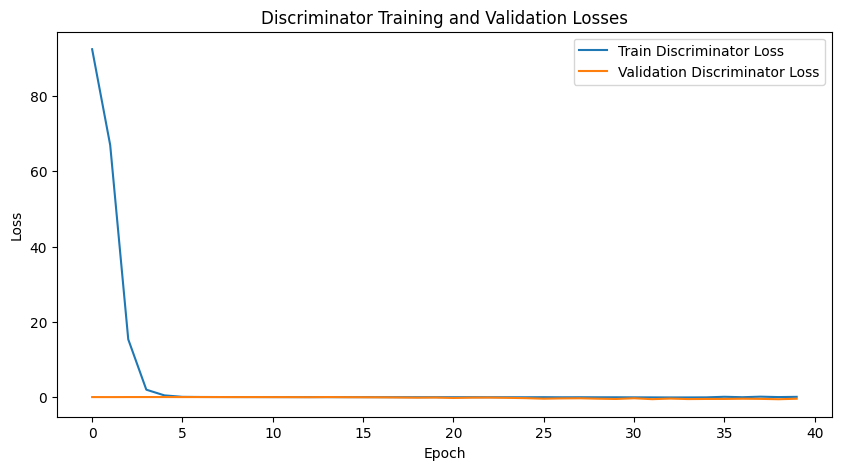

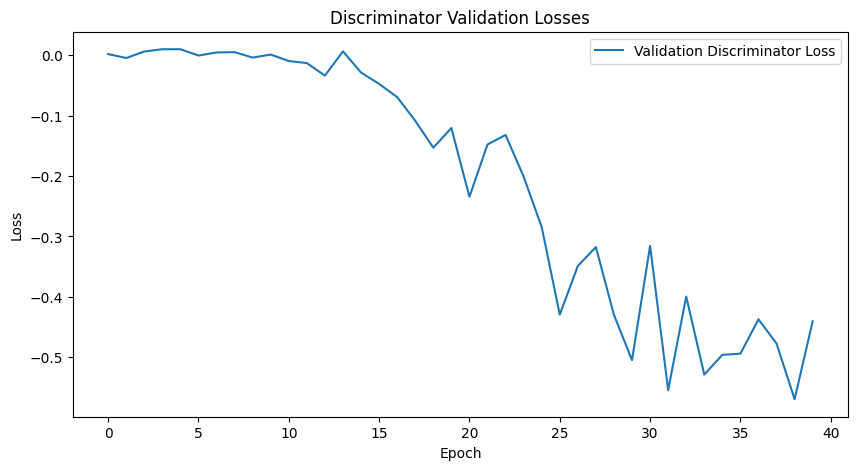

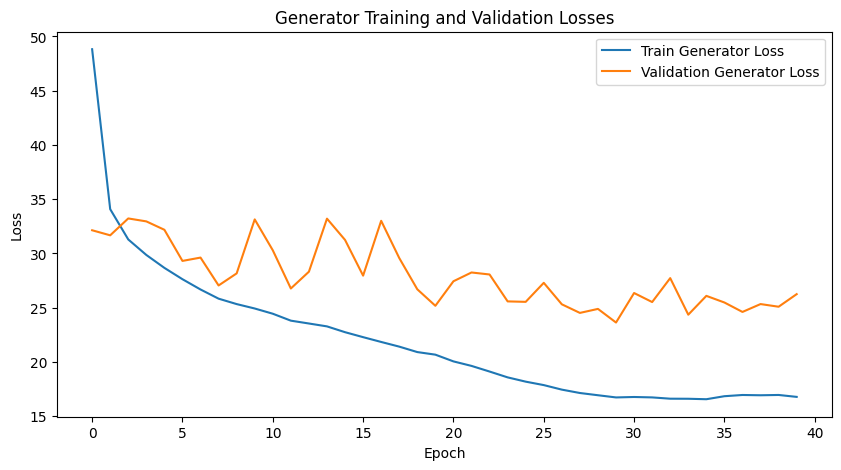

In [7]:
# Step 6: Visualize Training and Validation Losses
plt.figure(figsize=(10, 5))
plt.plot(train_d_losses, label='Train Discriminator Loss')
plt.plot(val_d_losses, label='Validation Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Discriminator Training and Validation Losses')
plt.show()

plt.figure(figsize=(10, 5))
# plt.plot(train_d_losses, label='Train Discriminator Loss')
plt.plot(val_d_losses, label='Validation Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Discriminator Validation Losses')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_g_losses, label='Train Generator Loss')
plt.plot(val_g_losses, label='Validation Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Generator Training and Validation Losses')
plt.show()

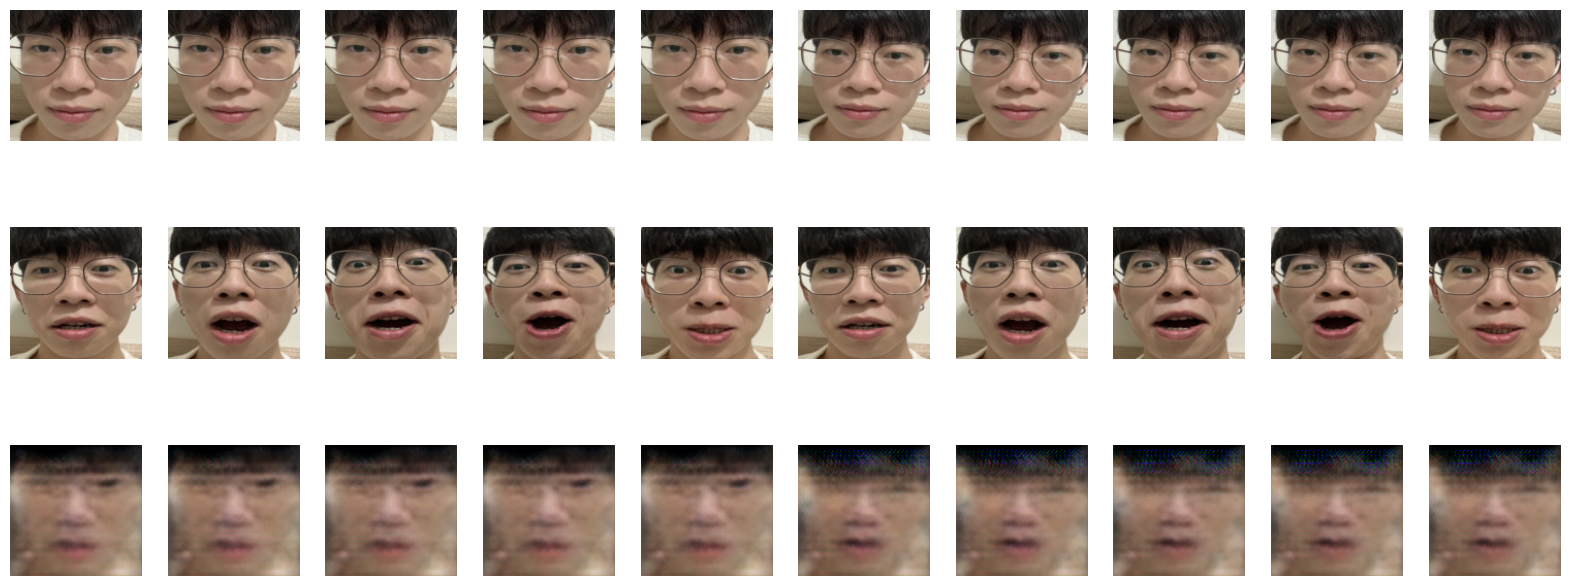

In [8]:
# Step 5: Test and Visualize Results
with torch.no_grad():
    neutral_images, happy_images = next(iter(val_loader))
    neutral_images = neutral_images.to(device)
    generated_images = generator(neutral_images).cpu()

# Save the generated images to disk
output_dir = 'generated_images'
os.makedirs(output_dir, exist_ok=True)
for i in range(len(generated_images)):
    image = generated_images[i].permute(1, 2, 0) * 0.5 + 0.5  # Denormalize
    image = (image.numpy() * 255).astype('uint8')
    img_pil = Image.fromarray(image)
    img_pil.save(f'{output_dir}/generated_image_{i}.png')

# Visualize original and generated images
n = 10  # Number of images to display
plt.figure(figsize=(20, 8))
for i in range(n):
    # Original neutral images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(neutral_images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
    plt.axis('off')

    # Target happy images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(happy_images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
    plt.axis('off')

    # Generated happy images
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(generated_images[i].permute(1, 2, 0) * 0.5 + 0.5)
    plt.axis('off')
plt.show()

In [9]:
# Step 5: Test and Visualize Results with Test Set
class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.test_dir = test_dir
        self.transform = transform
        self.image_paths = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, image_path

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_dataset = TestDataset(test_dir='./data/test_face', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

output_dir = f'test_generated_images_{emo[1]}'
os.makedirs(output_dir, exist_ok=True)

# Iterate through the test dataset
generator.eval()
with torch.no_grad():
    for test_image, image_path in test_loader:
        test_image = test_image.to(device)

        # Generate output using the trained generator
        generated_image = generator(test_image).cpu()

        # Denormalize and save the generated image
        generated_image = generated_image[0].permute(1, 2, 0) * 0.5 + 0.5
        generated_image = (generated_image.numpy() * 255).astype('uint8')
        img_pil = Image.fromarray(generated_image)

        # Extract the file name from the image path and save it to output directory
        filename = os.path.basename(image_path[0])
        img_pil.save(f'{output_dir}/{lambda_pixelwise}_{lambda_perceptual}_2l{emo[1]}_{filename}')

print("Test images processed and saved.")



Test images processed and saved.
